In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from IPython import display
import time
from torch.utils.data import DataLoader, Dataset
from unet import Unet, UnetOld


In [19]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [20]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)
np.max(test_data)
print(np.mean(test_data))

Test data shape:  (4, 320, 256, 256)
-0.058078725


In [21]:
class SimpleUNet(nn.Module):
    def __init__(self, has_timestep_embedding=None):
        super(SimpleUNet, self).__init__()
        if has_timestep_embedding:
            self.down1 = nn.Sequential(nn.Conv2d(2, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        else: 
            self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x, t=None):
        if t is not None:
            x_in = torch.cat((x, t), dim=1)
        else: 
            x_in = x

        down1 = self.down1(x_in)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [22]:
'''
Reading the pretrained parameters
'''
#has_timestep_embedding = False
#model = SimpleUNet(has_timestep_embedding)

with_attention = False
model = Unet(with_attention)
print(model)
if with_attention:
    state_dict = torch.load('unconditional_models/with_attention/fixed_output_trained_model_epoch426.pth', map_location=torch.device('cpu'), weights_only=True)
else:
    state_dict = torch.load('unconditional_models/with_timestep_embedding_new/fixed_output_trained_model_epoch500.pth', map_location=torch.device('cpu'), weights_only=True)

# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
#state_dict = torch.load('unconditional_models/fixed_output_trained_model_epoch400.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

Unet(
  (temb_layer): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (temb_proj1): Linear(in_features=128, out_features=64, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (temb_proj2): Linear(in_features=128, out_features=128, bias=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
def denoise(x_t, mask, y, model, step_size, beta_min = 1e-4, beta_max = 0.02, steps=1000, clip_gradient=False, grad_threshold=None):
    betas = torch.linspace(beta_min, beta_max, steps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    for t in reversed(range(steps)):
        alpha_t_bar = alphas_cumprod[t]
        alpha_t_bar_prev =  alphas_cumprod[t-1]
        beta_t = betas[t]
        alpha_t = alphas[t]
        
        nomalized_t = t / (steps)
        time_step_channel = torch.ones_like(x_t) * nomalized_t
        time_step_channel = time_step_channel.to(device)

        # Predict the noise using the model
        #epsilon_theta = model(x_t)
        #x_t_with_timestep = torch.cat((x_t, time_step_channel), dim=1)
        #epsilon_theta = model(x_t, time_step_channel)
        #epsilon_theta = model(x_t_with_timestep)
        #with torch.no_grad():
        epsilon_theta = model(x_t, torch.tensor(t, dtype=torch.float32, device=device).unsqueeze(0))

        score_unconditional = -epsilon_theta/torch.sqrt(1-alpha_t_bar)
        x0_hat = 1/torch.sqrt(alpha_t_bar) * (x_t + (1-alpha_t_bar) * score_unconditional)
        if t > 0:
            A = mask * x0_hat
            difference = y - A
            loss = torch.linalg.norm(difference)
            likelihood_grad = torch.autograd.grad(loss, x_t)[0]
            if clip_gradient:
                likelihood_grad_norm = torch.linalg.norm(likelihood_grad)
                likelihood_grad = likelihood_grad * (grad_threshold / (likelihood_grad_norm + 1e-8)) * (likelihood_grad_norm > grad_threshold) + likelihood_grad * (likelihood_grad_norm < grad_threshold)
            #print(torch.linalg.norm(likelihood_grad))
            mean =  (torch.sqrt(alpha_t) * (1-alpha_t_bar_prev))/(1 - alpha_t_bar) * x_t + (torch.sqrt(alpha_t_bar_prev) * beta_t)/(1 - alpha_t_bar) * x0_hat
            #
            z = torch.randn_like(x_t).to(device)
            x_t = mean + torch.sqrt(beta_t) * z
            x_t -= step_size * likelihood_grad

    return x0_hat



In [24]:
def denoise_dataloader(mask, y_dataloader, model, step_size, beta_min = 1e-4, beta_max = 0.02, steps=1000, clip_gradient=False, grad_threshold=None):
    images = []
    for i, y in enumerate(y_dataloader):
        print(i)
        x_t = torch.randn_like(y, requires_grad=True, dtype=torch.float32).to(device)
        y = y.detach().clone().to(device)
        generated_image = denoise(x_t, mask, y, model, step_size, clip_gradient=clip_gradient, grad_threshold=grad_threshold).reshape(-1,256,256).detach().cpu().numpy()
        print("Max in batch: ", np.max(np.abs((generated_image))))
        images.append(generated_image)
    images = np.concatenate(images, axis=0)
    return images

In [25]:
class NumpyDataset(Dataset):
    def __init__(self, data):
        # Reshape the data to create individual samples
        self.data = data.reshape(-1, 256, 256)
        # Normalize the data to [-1, 1]
        #self.data = 2 * (self.data - np.min(self.data)) / (np.max(self.data) - np.min(self.data)) - 1
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        return torch.tensor(image, dtype=torch.float32)

In [28]:
#Randomly choose a fixed percentage of points from the test snapshot
trajectory = 3
percentage = 0.1
factor = percentage/100
start_idx = 85
end_idx = 86
N = int(256**2 * factor)
test_snapshots = test_data[:, start_idx : end_idx]

nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
#nx = 50 * np.ones((128,)).astype(np.int16)
#ny = np.arange(0,256,2)

sparse_measurement =  test_snapshots[..., nx, ny]
plot_idx = 0
mask = np.zeros_like(test_snapshots[trajectory])
mask[..., nx, ny] = 1
print(np.sum(mask))
y = test_snapshots[trajectory] * mask
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
#ax.scatter(xx*mask, yy*mask, s=1, c="black", alpha=0.5)

measurement_std = 0.0
measurement_noise = np.random.randn(*mask.shape) * measurement_std
y = y + measurement_noise * mask
y_dataset = NumpyDataset(y)
y_dataloader = DataLoader(y_dataset, batch_size=32, shuffle=False)

mask = torch.tensor(mask, requires_grad=True).to(device)
epsilon = torch.randn_like(mask, requires_grad=True, dtype=torch.float32).unsqueeze(1).to(device)

step_size= 1.0
clip_gradient = False
grad_threshold = 30
generated_sample = denoise_dataloader(mask, y_dataloader, model, step_size, clip_gradient=clip_gradient, grad_threshold = grad_threshold )
print(np.max(np.abs(generated_sample)))


65.0
0
tensor(8.2229, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5201, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6147, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.1261, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7309, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.2715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.1533, device='cuda:0', grad_fn=<MeanBackwar

0


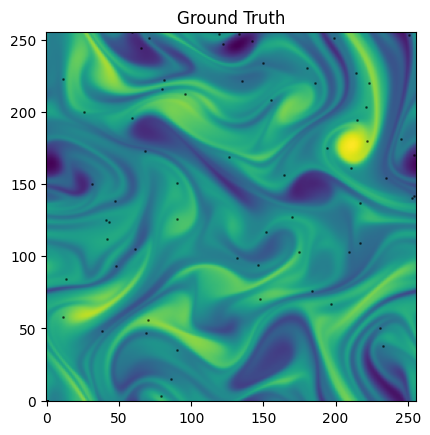

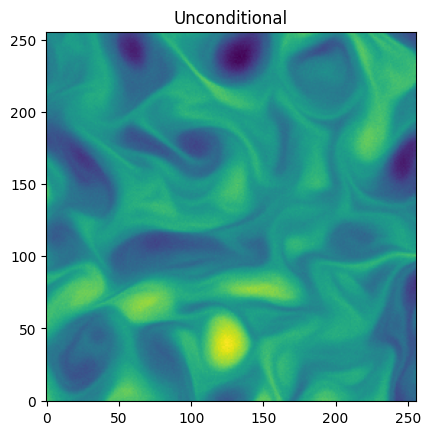

In [15]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
ax.imshow(test_snapshots[trajectory, plot_idx].squeeze(), origin="lower")
ax.scatter(xx*mask.detach().cpu().numpy(), yy*mask.detach().cpu().numpy(), s=1, c="black", alpha=0.5)
p = ax2.imshow(generated_sample[plot_idx], origin="lower")
ax2.set_title("Unconditional")
ax.set_title("Ground Truth")
#fig2.colorbar(p)
fig.savefig("plots/dps/Ground_Truth.png", dpi=400)
fig2.savefig("plots/dps/Unconditional_Sin.png", dpi=400)
print(np.sum(np.abs(generated_sample) > 1))

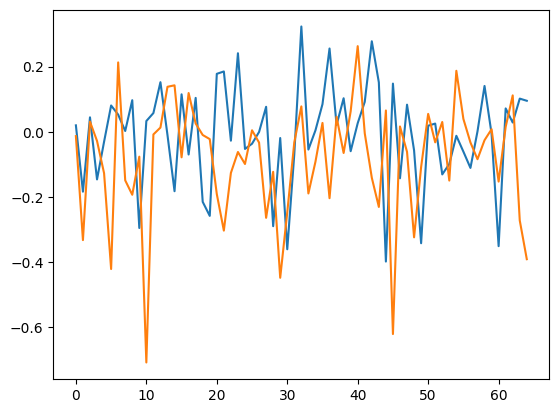

In [24]:
plt.plot(generated_sample[plot_idx, nx,ny])
plt.plot(test_snapshots[trajectory, plot_idx, nx,ny])

In [25]:
def two_point_corr(field, axis=0):
    number_of_cells = field.shape[axis]
    mean = np.mean(field)
    field_prime = field - mean
    var = np.var(field)
    f_corr = []
    for ii in range(number_of_cells // 2):
        f_corr_ii = np.mean(field_prime * np.roll(field_prime, shift=ii, axis=axis)) / var # longitudinal
        f_corr.append(f_corr_ii)
    f_corr = np.array(f_corr)
    return f_corr

In [35]:
import os
print(percentage)
description = "new_embedding"

if step_size == 0:
    name = "unconditional" 
else:
    name = "step_size"  + "_" + "p" + "_" + str(percentage) 

name = name +   "_" + description

root = "generated_samples/timestep_input_comparison/"
name = root + name 

if not os.path.exists(root):
    os.makedirs(root)

name = name + ".npy"
np.save(name, generated_sample)


0.1


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of parameters: {count_parameters(model)}')


Total number of parameters: 1964993


194665 unconditional.npy
(100, 256, 256) (100, 256, 256)
(100, 256)
42 unconditional_with_timestep_input.npy
(100, 256, 256) (100, 256, 256)
(100, 256)
0 unconditional_new_embedding.npy
(100, 256, 256) (100, 256, 256)
(100, 256)
0 unconditional_with_sin_embedding.npy
(100, 256, 256) (100, 256, 256)
(100, 256)
89 unconditional_with_attention.npy
(100, 256, 256) (100, 256, 256)
(100, 256)
(100, 256, 256) (100, 256, 256)
(100, 256)


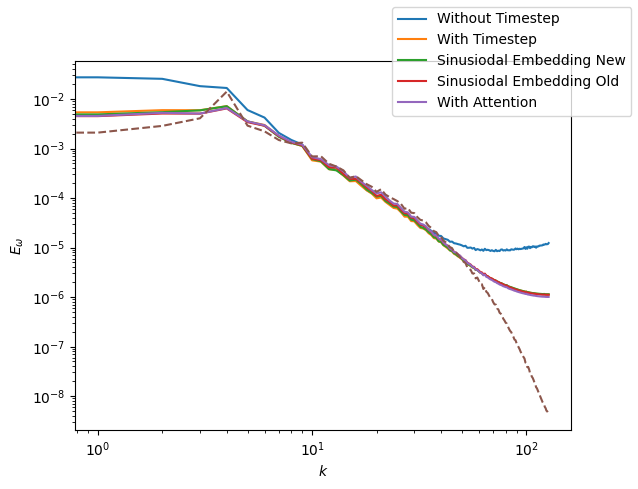

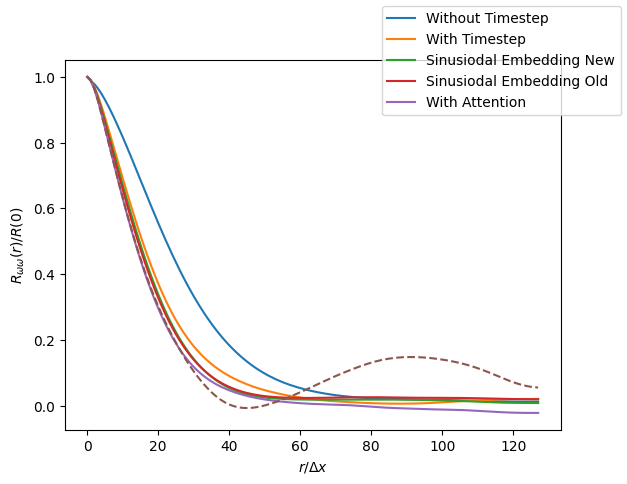

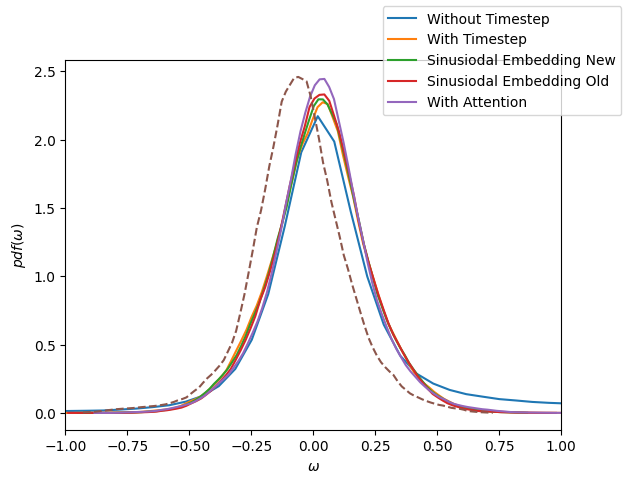

In [38]:
from energy_spectrum import compute_tke_spectrum
def denormalize(data, min, max):
    return min + (1 + data) * (max - min)/2

fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
plot_idx = 10

#data = np.load("/home/baris/Documents/DDSim/Diffusion-based-Fluid-Super-resolution/data/kf_2d_re1000_256_40seed.npy")
#train_data = data[:-4]
#test_data = data[-4:]

#minimum_train, maximum_train = np.min(train_data), np.max(train_data)
subdir = "timestep_input_comparison"
joined_name = os.path.join("generated_samples", subdir)
names = os.listdir(joined_name)

#names = sorted(os.listdir(joined_name))[::-1]
#names = [names[0]] + names[:0:-1]
#names =  names.append(names.pop(0))
first = names.pop(0)
names.append(first)

two_point_corrs = []
spectra = []
pdfs = []
bins_list = []
for name in names:
    generated_sample_numpy = np.load(os.path.join(joined_name, name))
    print(np.sum(np.abs(generated_sample_numpy) > 1), name)
    test_snapshots_100 = np.load("test_snapshots_100.npy")
    #generated_sample_numpy = denormalize(generated_sample_numpy)
    _, wavenumbers, spectrum = compute_tke_spectrum(generated_sample_numpy, 2 * np.pi, 2 * np.pi)
    spectrum = np.mean(spectrum, axis=0)
    pdf, bins = np.histogram(generated_sample_numpy.flatten(), bins=100, density=True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    two_point_correlation = two_point_corr(generated_sample_numpy, axis=1)
    spectra.append(spectrum)
    two_point_corrs.append(two_point_correlation)
    pdfs.append(pdf)
    bins_list.append(bins)

spectra = np.array(spectra)
two_point_corrs = np.array(two_point_corrs)
bins = np.array(bins_list)
pdfs = np.array(pdfs)

_, wavenumbers, spectrum_ground_truth = compute_tke_spectrum(test_snapshots_100, 2 * np.pi, 2 * np.pi)
spectrum_ground_truth = np.mean(spectrum_ground_truth, axis=0)
two_point_correlation_gt = two_point_corr(test_snapshots_100, axis=1)
pdf_ground_truth, bins_gt = np.histogram(test_snapshots_100.flatten(), bins=100, density=True)
bins = bins.T
dx = (np.max(test_snapshots_100) - np.min(test_snapshots_100))/100
dx_generated = bins[1:] - bins[:-1]

ax.plot(wavenumbers[:128], spectra.T[:128])
ax.plot(wavenumbers[:128], spectrum_ground_truth[:128], "--")
ax2.plot(two_point_corrs.T)
ax2.plot(two_point_correlation_gt, "--")
ax3.plot((bins[1:] + bins[:-1])/2, pdfs.T)

ax3.plot((bins_gt[1:] + bins_gt[:-1])/2, pdf_ground_truth, "--")
#ax3.set_ylim([1e-2, 2.55])
ax3.set_xlim([-1,1])

legend_dict = {"timestep_input_comparison" : ["Without Timestep", "With Timestep", "Sinusiodal Embedding New", "Sinusiodal Embedding Old", "With Attention"],
              "percentage" : ["Unconditional", "0.1%", "1%", "10%", "Ground Truth"], 
              "step_size" : ["Unconditional", "Step Size 0.5", "Step Size 1.0", "Ground Truth"],
              "da_0.1p" : ["With Attention", "Without Attention", "Ground Truth"],
              "da_1p" : ["With Attention", "Without Attention", "Ground Truth"]}

legend = legend_dict[subdir]

fig.legend(legend)
fig2.legend(legend)
fig3.legend(legend)

ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$E_{\omega}$")
ax2.set_xlabel(r"$r/\Delta x$")
ax2.set_ylabel(r"$R_{\omega\omega}(r)/R(0)$")
ax3.set_xlabel(r"$\omega$")
ax3.set_ylabel(r"$pdf(\omega)$")

path = "plots/dps/" + subdir
if not os.path.exists(path):
    os.makedirs(path)
#fig.savefig(os.path.join(path, "dps_spectrum.png"), dpi=400)
#fig2.savefig(os.path.join(path, "dps_correlation.png"), dpi=400)
#fig3.savefig(os.path.join(path, "dps_pdf.png"), dpi=400)


In [ ]:
ensemble_size = 100
ensemble_list = []

epsilon = torch.randn_like(mask, requires_grad=True, dtype=torch.float32).unsqueeze(0).to(device)

print(y.shape)
step_size=  1,0
measurement_std = 0.05
masks = []
for i in range(ensemble_size):
    print(i)
    measurement_noise = torch.randn_like(mask, dtype=torch.float32) * measurement_std
    y_in = torch.tensor(y, dtype=torch.float32).to(device) + measurement_noise * mask
    generated_sample = denoise(epsilon, mask, y_in, model, step_size).squeeze().detach().cpu().numpy()
    ensemble_list.append(generated_sample[..., nx, ny])
ensemble = np.stack(ensemble_list)
ensemble_variance = np.var(ensemble, axis=0)
print(ensemble_variance)



(1, 256, 256)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


KeyboardInterrupt: 

(100, 128)


np.float32(0.0031571402)

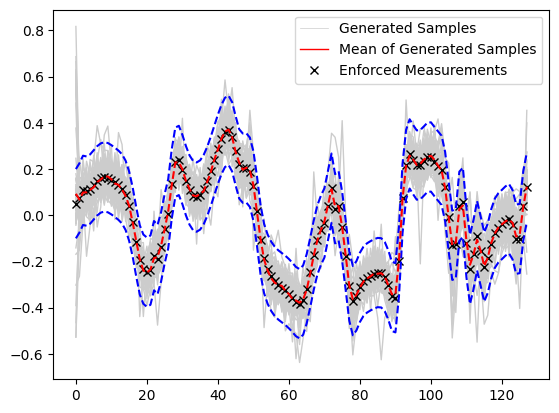

In [57]:
from matplotlib.lines import Line2D
ensemble_mean = np.mean(ensemble, axis=0)
print(ensemble.shape)
plt.plot(ensemble.T,  color="0.8", linewidth=1)
plt.plot(y[...,nx,ny].squeeze(), "x", color="k", linestyle="None")
plt.plot(y[...,nx,ny].squeeze() + 3 * measurement_std, "b--")
plt.plot(y[...,nx,ny].squeeze() - 3 * measurement_std, "b--")

#plt.errorbar(np.arange(128), y[...,nx,ny].squeeze(), yerr=2 * measurement_std, marker="o", linestyle='none')

plt.plot(ensemble_mean, "r", linestyle="--")
gray_lines = Line2D([0], [0], color='0.8', linewidth=0.5)
black_lines = Line2D([0], [0], color='k', linewidth=1, marker="x", linestyle="None")
red_lines = Line2D([0], [0], color='r', linewidth=1)
plt.legend([gray_lines, red_lines, black_lines], ["Generated Samples", "Mean of Generated Samples", "Enforced Measurements"])
plt.savefig("plots/dps/ensemble.png", dpi=400)
np.mean(ensemble_variance)

In [53]:

print(np.mean(ensemble_variance), torch.var(measurement_noise))

0.0031571402 tensor(0.0025, device='cuda:0')


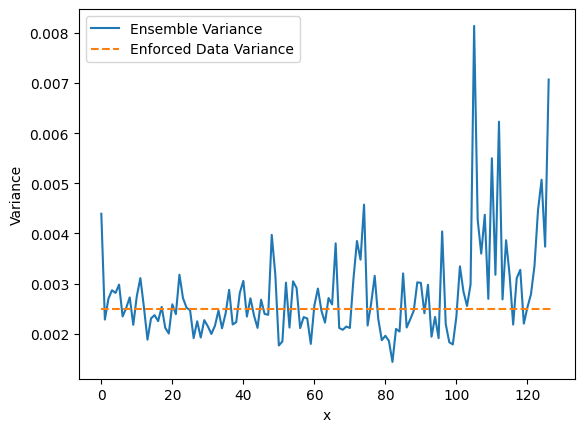

In [52]:
plt.plot(ensemble_variance[1:])
plt.plot(np.ones((128,))*measurement_std**2, "--")
plt.xlabel("x")
plt.ylabel("Variance")
plt.legend(["Ensemble Variance", "Enforced Data Variance"])

plt.savefig("plots/dps/Ensemble_Variance.png", dpi=400)


-0.058078676 (array([ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),) (array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,

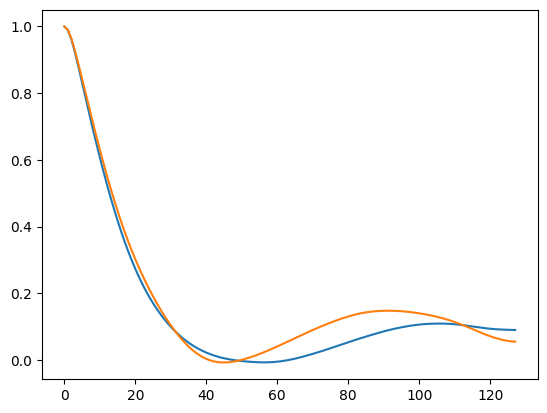

In [39]:
two_point_corr_entire_dataset = two_point_corr(test_data[3], axis=1)
two_point_corr_200_300 = two_point_corr(test_data[3, 200:300], axis=1)
print(np.mean(test_data[3]), np.where(two_point_corr_entire_dataset < 0.2), np.where(two_point_corr_200_300 < 0.2))
plt.plot(two_point_corr_entire_dataset)
plt.plot(two_point_corr_200_300)